# Gemini for multi-modal prompting


## Learning Objective


**Learning Objective**

1. Learn how to generate text from text prompts using the `gemini-pro` API
1. Learn how to explore various features and configuration options 
1. Learn how to generate text from image(s) and text prompts with the `gemini-pro-vision` API
1. Learn how to generate text from video and text prompts with the `gemini-pro-vision` API


In this notebook, you will learn how to use the Vertex AI Gemini API with the Vertex AI SDK for Python to interact with the Gemini Pro (`gemini-pro`) model and the Gemini Pro Vision (`gemini-pro-vision`) model.
Gemini is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini Pro Vision and Gemini Pro models.

The Vertex AI Gemini API provides a unified interface for interacting with Gemini models. There are currently two models available in the Gemini API:

- **Gemini Pro model** (`gemini-pro`): Designed to handle natural language tasks, multiturn text and  chat, and code generation.
- **Gemini Pro Vision model** (`gemini-pro-vision`): Supports multimodal prompts. You can include text, images, and video in your prompt requests and get text or code responses.

You can interact with the Gemini API using the following methods:

- Use the [Vertex AI Studio](https://cloud.google.com/generative-ai-studio) for quick testing and command generation
- Use cURL commands
- Use the Vertex AI SDK

This notebook focuses on using the **Vertex AI SDK for Python** to call the Vertex AI Gemini API.

For more information, see the [Generative AI on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview) documentation.


### Setup

For this lab, you'll first need to build a special kernel containing all the dependencies we will need:

In [ ]:
!cd ~/asl-ml-immersion && make gemini_kernel

Then you'll need to select the kernel in the notebook. Click on the current kernel on the top right corner of the notebook:


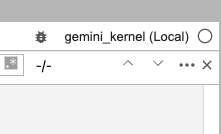

### Import libraries

In [ ]:
from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

## Use the Gemini Pro model

The Gemini Pro (`gemini-pro`) model is designed to handle natural language tasks, multiturn text and code chat, and code generation.


### Load the Gemini Pro model


In [ ]:
model = GenerativeModel("gemini-pro")

### Generate text from text prompts

Send a text prompt to the model. The Gemini Pro (`gemini-pro`) model provides a streaming response mechanism. With this approach, you don't need to wait for the complete response; you can start processing fragments as soon as they're accessible.


In [ ]:
responses = model.generate_content("Why is the sky blue?", stream=True)

for response in responses:
    print(response.text, end="")

#### Try your own prompts

- What are the biggest challenges facing the healthcare industry?
- What are the latest developments in the automotive industry?
- What are the biggest opportunities in retail industry?
- (Try your own prompts!)


In [ ]:
prompt = """Create a numbered list of 10 items. Each item in the list should be a trend in the tech industry.

Each trend should be less than 5 words."""  # try your own prompt

responses = model.generate_content(prompt, stream=True)

for response in responses:
    print(response.text, end="")

#### Model parameters

Every prompt you send to the model includes parameter values that control how the model generates a response. The model can generate different results for different parameter values. The `temperature` parameter controls the amount of consistency in the response. With a temperature of 0 you'll consistently get the exact same answer to the same prompt, and as you increase the temperature you'll get more "creative" albeit less consistent answers. The `top_p` and `top_k` control the tokens that are considered by the LLM to generate the answer. If you set `top_p` to 0.2 for instance, the model will only consider the most probable token for an answer whose probability sums up to 0.2, while if you set `top_k` to 100, the model will only consider the top 100 most probable tokens.  `candidate_counts` determines the number of candidate answers you want to be generated, while `max_output_tokens` specifies the maximum number of tokens allowed per candidate answer. 


You can experiment with different model parameters to see how the results change.


In [ ]:
generation_config = GenerationConfig(
    temperature=0.9,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=8192,
)

responses = model.generate_content(
    "Why is the sky blue?",
    generation_config=generation_config,
    stream=True,
)

for response in responses:
    print(response.text, end="")

### Test chat prompts

The Gemini Pro model supports natural multi-turn conversations and is ideal for text tasks that require back-and-forth interactions. The following examples show how the model responds during a multi-turn conversation.


In [ ]:
chat = model.start_chat()

prompt = """My name is Ned. You are my personal assistant. My favorite movies are Lord of the Rings and Hobbit.

Suggest another movie I might like.
"""

responses = chat.send_message(prompt, stream=True)

for response in responses:
    print(response.text, end="")

This follow-up prompt shows how the model responds based on the previous prompt:


In [ ]:
prompt = "Are my favorite movies based on a book series?"

responses = chat.send_message(prompt, stream=True)

for response in responses:
    print(response.text, end="")

You can also view the chat history:


In [ ]:
print(chat.history)

## Use the Gemini Pro Vision model

Gemini Pro Vision (`gemini-pro-vision`) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.


### Load the Gemini Pro Vision model


In [ ]:
multimodal_model = GenerativeModel("gemini-pro-vision")

### Define helper functions

Define helper functions to load and display images.


In [ ]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_url_from_gcs(gcs_uri: str) -> str:
    # converts gcs uri to url for image display.
    url = "https://storage.googleapis.com/" + gcs_uri.replace(
        "gs://", ""
    ).replace(" ", "%20")
    return url


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

### Generate text from local image and text

Use the `Image.load_from_file` method to load a local file as the image to generate text for.


In [ ]:
# Download an image from Google Cloud Storage
! gsutil cp "gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg" ./image.jpg

# Load from local file
image = Image.load_from_file("image.jpg")

# Prepare contents
prompt = "Describe this image?"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Generate text from text & image(s)


#### Images with Cloud Storage URIs

If your images are stored in [Cloud Storage](https://cloud.google.com/storage/docs), you can specify the Cloud Storage URI of the image to include in the prompt. You must also specify the `mime_type` field. The supported MIME types for images include `image/png` and `image/jpeg`.

Note that the URI (not to be confused with URL) for a Cloud Storage object should always start with `gs://`.

In [ ]:
# Load image from Cloud Storage URI
gcs_uri = "gs://cloud-samples-data/generative-ai/image/boats.jpeg"

# Prepare contents
image = Part.from_uri(gcs_uri, mime_type="image/jpeg")
prompt = "Describe the scene?"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

#### Images with direct links

You can also use direct links to images, as shown below. The helper function `load_image_from_url()` (that was declared earlier) converts the image to bytes and returns it as an Image object that can be then be sent to Gemini Pro Vision along with the text prompt.

In [ ]:
# Load image from Cloud Storage URI
image_url = "https://storage.googleapis.com/cloud-samples-data/generative-ai/image/boats.jpeg"
image = load_image_from_url(image_url)  # convert to bytes

# Prepare contents
prompt = "Describe the scene?"
contents = [image, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

#### Combining multiple images and text prompts for few-shot prompting

You can send more than one image at a time, and also place your images anywhere alongside your text prompt.

In the example below, few-shot prompting is performed to have Gemini Pro Vision return the city and landmark in a specific JSON format.

In [ ]:
# Load images from Cloud Storage URI
image1_url = (
    "https://storage.googleapis.com/github-repo/img/gemini/intro/landmark1.jpg"
)
image2_url = (
    "https://storage.googleapis.com/github-repo/img/gemini/intro/landmark2.jpg"
)
image3_url = (
    "https://storage.googleapis.com/github-repo/img/gemini/intro/landmark3.jpg"
)
image1 = load_image_from_url(image1_url)
image2 = load_image_from_url(image2_url)
image3 = load_image_from_url(image3_url)

# Prepare prompts
prompt1 = """{"city": "London", "Landmark:", "Big Ben"}"""
prompt2 = """{"city": "Paris", "Landmark:", "Eiffel Tower"}"""

# Prepare contents
contents = [image1, prompt1, image2, prompt2, image3]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Generate text from a video file

Specify the Cloud Storage URI of the video to include in the prompt. The bucket that stores the file must be in the same Google Cloud project that's sending the request. You must also specify the `mime_type` field. The supported MIME type for video includes `video/mp4`.


In [ ]:
file_path = "github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4"
video_uri = f"gs://{file_path}"
video_url = f"https://storage.googleapis.com/{file_path}"

IPython.display.Video(video_url, width=450)

In [ ]:
prompt = """
Answer the following questions using the video only:
What is the profession of the main person?
What are the main features of the phone highlighted?
Which city was this recorded in?
Provide the answer JSON.
"""

video = Part.from_uri(video_uri, mime_type="video/mp4")
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

for response in responses:
    print(response.text, end="")

## Acknowledgement 

This notebook is adapted from a [tutorial](https://github.com/GoogleCloudPlatform/generative-ai/commits/main/gemini/getting-started/intro_gemini_python.ipynb)
written by Polong Lin.

Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.